In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans, Birch
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

## Načtení datasetu do práce na kole

In [3]:
df_dpnk = pd.read_csv('./data_project3/dpnk.csv')
df_dpnk

,OBJECTID,GID_ROAD,data_2018,data_2019,data_2020,data_2021,dpnk_22,GlobalID,SHAPE_Length
0,1,3512,0,0,0,1,2.0,{18682DE8-C98F-4A17-B74E-13614BB9274E},0.002066
1,2,3515,3,5,3,34,15.0,{F7E4061B-AD4A-4E77-8FC2-1A310314A990},0.000113
2,3,3516,10,17,10,49,14.0,{56988C51-BD9B-4AC1-806F-C5DF0CD32CCB},0.000821
3,4,4168,2,4,2,7,38.0,{9A89DC54-871A-47C8-B35F-F5E2AD66ED8F},0.001342
4,5,4169,1,1,1,18,11.0,{6245952B-3ADC-4983-A9D6-D3BB6BE633D8},0.000630
...,...,...,...,...,...,...,...,...,...
65172,65173,255288,4,6,4,0,NaN,{63553F68-9B0D-4BF7-8970-EDF1D0A6E2C7},0.000906
65173,65174,255291,2,3,2,0,NaN,{6B6B11FF-581F-43EC-BAC7-6751CA3B08B5},0.000507
65174,65175,255292,0,0,0,0,NaN,{2FA6E19A-C588-4257-B7D6-4BA5226CEF33},0.000414
65175,65176,255332,1,1,1,0,NaN,{F41405B9-2F70-493C-9D87-0E5E9C896D55},0.000164


## Načtení datasetu cyklo infrastruktury

In [18]:
df_roads = pd.read_csv('./data_project3/Cykloopatreni.csv')
# delka je v metrech
df_roads =  df_roads.drop(df_roads[df_roads['rok_realizace'] == 0].index) # deletes rows with year == 0
df_roads['rok_realizace'] = df_roads['rok_realizace'].astype('Int64') # year into int type
# zrušená infrastruktura vyjádřena zápornou délkou, příprava pro lineární regresi
df_roads.loc[df_roads[df_roads['typ_opatreni'] == 'Úsek byl zrušen'].index, 'delka'] = df_roads['delka'].loc[df_roads[df_roads['typ_opatreni'] == 'Úsek byl zrušen'].index] * -1
df_roads.loc[df_roads[df_roads['typ_opatreni'] == 'Vjezd cyklistům zakázán'].index, 'delka'] = df_roads['delka'].loc[df_roads[df_roads['typ_opatreni'] == 'Vjezd cyklistům zakázán'].index] * -1
df_roads

,ObjectId,ogcfid,typ_opatreni,rok_realizace,delka,datum_exportu,GlobalID,SHAPE_Length
0,1,639,Jízda cyklistů v protisměru (piktogram),2021,149.770000,2022/12/16 00:00:00+00,{F1050389-0266-46A5-8281-AD60711AE90A},0.002029
1,2,297,Jízda cyklistů v protisměru (piktogram),2017,71.870003,2022/12/16 00:00:00+00,{04371385-F368-42FD-9B83-3DAD4033D0EE},0.000657
2,3,712,Stezka pro chodce s povoleným vjezdem cyklistů,2022,53.349998,2022/12/16 00:00:00+00,{39E0D50A-C566-4DF7-9BFA-6F603262172E},0.000486
3,4,641,Jízda cyklistů v protisměru (piktogram),2021,248.250000,2022/12/16 00:00:00+00,{84B6FC27-C62C-4AB4-9761-2117FF06B4A0},0.003363
4,5,336,Piktogramový koridor pro cyklisty - V20,2015,81.139999,2022/12/16 00:00:00+00,{C5C495C3-0BB3-4AEA-BAF0-8C61C062742A},0.000821
...,...,...,...,...,...,...,...,...
594,595,452,Vjezd cyklistům povolen,2015,17.150000,2022/12/16 00:00:00+00,{E8439F05-0558-4327-B7EB-A345D64EB462},0.000235
595,596,298,Jízda cyklistů v protisměru (piktogram),2014,130.990010,2022/12/16 00:00:00+00,{8251BC80-4D0F-40E3-987B-23BF466A0AEB},0.001463
596,597,152,Jízda cyklistů v protisměru - E12,2014,153.330000,2022/12/16 00:00:00+00,{402C1981-C3AC-4164-88ED-2473DD3BFB08},0.000000
597,598,299,Piktogramový koridor pro cyklisty - V20,2014,132.759990,2022/12/16 00:00:00+00,{F03B079F-9DF5-475F-B46D-0AD4A7FEE5D2},0.000000


In [26]:
df_roads.loc[df_roads[df_roads['delka'] == 270.790010].index]

,ObjectId,ogcfid,typ_opatreni,rok_realizace,delka,datum_exportu,GlobalID,SHAPE_Length
51,52,655,Piktogramový koridor pro cyklisty - V20,2019,270.79001,2022/12/16 00:00:00+00,{DFFA3344-923D-4B89-BB75-55E903383918},0.003396
322,323,332,Vyhrazený jízdní pruh pro cyklisty - V14,2007,270.79001,2022/12/16 00:00:00+00,{F636F81E-06FD-43C5-9C12-2C34A82EDF40},0.003549


In [23]:
df_roads['delka'].value_counts()

 76.169998     4
 270.790010    2
 41.490002     2
 129.950000    2
 51.650002     2
              ..
 468.320010    1
 25.309999     1
 402.260010    1
 251.640000    1
-55.509998     1
Name: delka, Length: 526, dtype: int64

## Tvorba datasetu s hodnotami za celé roky
Délka cykloinfrastruktury se bere jako součet hotových úseků před daným rokem

In [5]:
# total number of cyclists per year
df2 = df_dpnk[['data_2018', 'data_2019', 'data_2020', 'data_2021', 'dpnk_22']].sum(axis=0).reset_index()
df2['rok'] = range(2018,2023)
# counting number of segments made before each year
df2.loc[0, 'num_opatreni'] = df_roads['rok_realizace'].loc[df_roads[df_roads['rok_realizace'] < 2018].index].count()
# substracting removed infrastructure from count
df2.loc[0, 'num_opatreni'] -= df_roads.loc[df_roads[df_roads['delka'] < 0].index].shape[0]
# total number of segments
df2.loc[0, 'total_num'] = 0
# length of segments made before each year [m]
df2.loc[0, 'length_opatreni'] = df_roads['delka'].loc[df_roads[df_roads['rok_realizace'] < 2018].index].sum().round()
for i in range(4):
    df2.loc[i+1, 'num_opatreni'] = df_roads['rok_realizace'].loc[df_roads[df_roads['rok_realizace'] == 2018+i].index].count()
    df2.loc[i+1, 'length_opatreni'] = df_roads['delka'].loc[df_roads[df_roads['rok_realizace'] == 2018+i].index].sum().round()
    df2.loc[i+1, 'total_length'] = df_roads['delka'].loc[df_roads[df_roads['rok_realizace'] <= 2018+i].index].sum().round()
df2['total_num'] = df2['num_opatreni'].cumsum()
# total length of segments [km]
df2['total_length'] = (df2['length_opatreni'].cumsum() / 1000).round(1)
df2.rename(columns={'index': 'popis', 0: 'num_cyclists'}, inplace=True)
df2

,popis,num_cyclists,rok,num_opatreni,total_num,length_opatreni,total_length
0,data_2018,1571704.0,2018,415.0,415.0,103435.0,103.4
1,data_2019,2570673.0,2019,35.0,450.0,8707.0,112.1
2,data_2020,1549761.0,2020,27.0,477.0,5739.0,117.9
3,data_2021,3299232.0,2021,13.0,490.0,3912.0,121.8
4,dpnk_22,3652385.0,2022,21.0,511.0,6044.0,127.8


## Lineární regrese
Hodnoty X = délka infrastruktury, hodnoty y = celkový počet cyklistů
Predikce posledního roku

In [6]:
# linear regression X=length of cycling ingrastructure, y=number of cyclists each year
X = df2.loc[:3, 'total_length'].to_numpy().reshape(-1,1)
y = df2.loc[:3, 'num_cyclists']
regr = linear_model.LinearRegression()
regr.fit(X, y)
print(f"prediction of {df2.loc[4, 'total_length']}: {int(regr.predict([[df2.loc[4, 'total_length']]]).round()[0])} cyklistů")

prediction of 127.8: 3125817 cyklistů


## Porovnání lineárni regrese pro všechny roky s víše predikovanou

[Text(0.5, 0, 'Délka cykloinfrastruktury [km]'),
 Text(0, 0.5, 'Počet cyklistů'),
 Text(0.5, 1.0, 'Lineární regrese')]

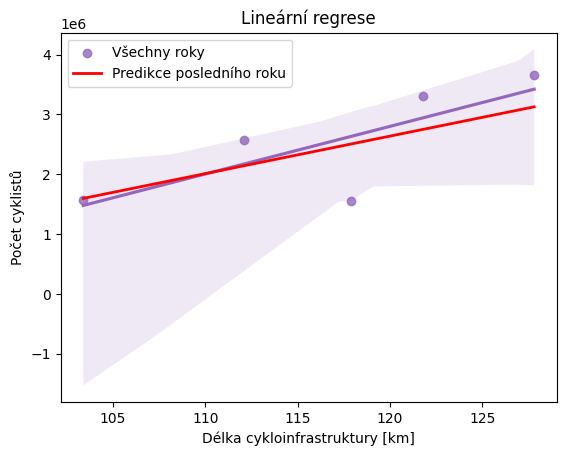

In [7]:
g = sns.regplot(data=df2, x='total_length', y='num_cyclists', color='tab:purple', ci=95, label='Všechny roky')
sns.lineplot(x=df2['total_length'], y=regr.intercept_ + regr.coef_* df2['total_length'], linewidth=2, color='red', label='Predikce posledního roku')
g.set(xlabel='Délka cykloinfrastruktury [km]', ylabel='Počet cyklistů', title='Lineární regrese')

## Trend celkové délky cyklo infrastruktury

In [17]:
df_realizace = df_roads[['rok_realizace', 'delka']].groupby(['rok_realizace']).sum().reset_index()
df_realizace.iloc[-1] = [1996.0, 0.0]
df_realizace.sort_values(by=['rok_realizace'], inplace=True)
df_realizace['total_delka'] = df_realizace['delka'].cumsum() / 1000
df_realizace['rok_realizace'] = df_realizace['rok_realizace'].astype('float64') # linear regression needs float
df_realizace

,rok_realizace,delka,total_delka
0,1994.0,576.760000,0.57676
1,1995.0,1733.770008,2.31053
2,1997.0,3774.150102,6.08468
3,1998.0,5664.729962,11.74941
4,1999.0,4334.469956,16.08388
5,2000.0,2801.879980,18.88576
6,2001.0,3734.580030,22.62034
7,2002.0,5758.850010,28.37919
8,2003.0,971.439980,29.35063
9,2004.0,1791.140020,31.14177


In [37]:
import altair as alt
progress_chart = (
    alt.Chart(df_realizace)
    .mark_bar()
    .encode(
        x=alt.X("rok_realizace:O", axis=alt.Axis(title="Year")),
        y=alt.Y("delka:Q", axis=alt.Axis(title="Length of infrastructure built that year [m]")),
    )
)
progress_chart

NameError: name 'df_realizace' is not defined

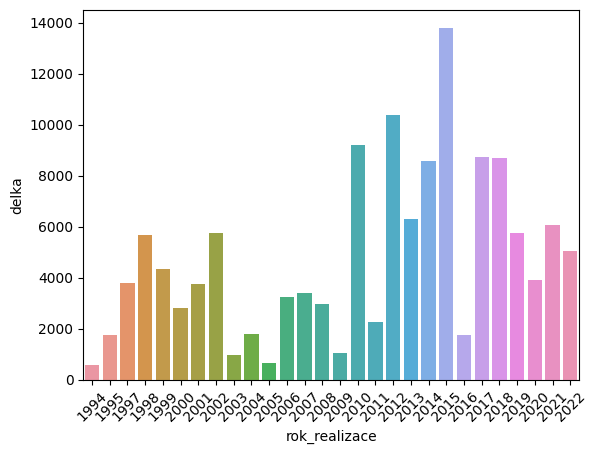

In [11]:
g = sns.barplot(df_realizace, x='rok_realizace', y='delka')
g.tick_params(axis='x', rotation=45)

In [115]:
def get_reg_fit(data, yvar, xvar, alpha=0.05):
    import statsmodels.formula.api as smf

    # Grid for predicted values
    x = data.loc[pd.notnull(data[yvar]), xvar]
    grid = np.arange(x.min(), x.max()+0.001)
    predictions = pd.DataFrame({xvar: grid})

    # Fit model, get predictions
    model = smf.ols(f"{yvar} ~ {xvar}", data=data).fit()
    model_predict = model.get_prediction(predictions[xvar])
    predictions[yvar] = model_predict.summary_frame()["mean"]
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=alpha)
    predictions[xvar] = predictions[xvar].astype("Int64")

    # Build chart
    reg = alt.Chart(predictions).mark_line().encode(x=f"{xvar}:O", y=f"{yvar}:Q")
    ci = (
        alt.Chart(predictions)
        .mark_errorband()
        .encode(
            x=f"{xvar}:O",
            y=alt.Y("ci_low:Q", title=yvar),
            y2="ci_high:Q",
        )
    )
    chart = ci + reg
    return predictions, chart

In [116]:
fit, reg_chart = get_reg_fit(df_realizace, yvar="total_delka", xvar="rok_realizace", alpha=0.05)
fit.head()

,rok_realizace,total_delka,ci_low,ci_high
0,1994,-13.665682,-21.036575,-6.294789
1,1995,-8.809070,-15.797176,-1.820963
2,1996,-3.952457,-10.565461,2.660547
3,1997,0.904155,-5.342815,7.151124
4,1998,5.760767,-0.130926,11.652460


In [117]:
chart = (
    alt.Chart(df_realizace)
    .mark_point(color="red", size=60, filled=True)
    .encode(
        x=alt.X("rok_realizace:O", axis=alt.Axis(title="Year"), scale=alt.Scale(zero=False)),
        y=alt.Y("total_delka:Q", axis=alt.Axis(title="Total infrastructure length [km]")),
    )
)
chart

alt.Chart(...)

In [118]:
chart + reg_chart

alt.LayerChart(...)

[Text(0.5, 0, 'Rok realizace'),
 Text(0, 0.5, 'Délka cykloinfrastruktury [km]'),
 Text(0.5, 1.0, 'Lineární regrese celkové délky cykloopatření')]

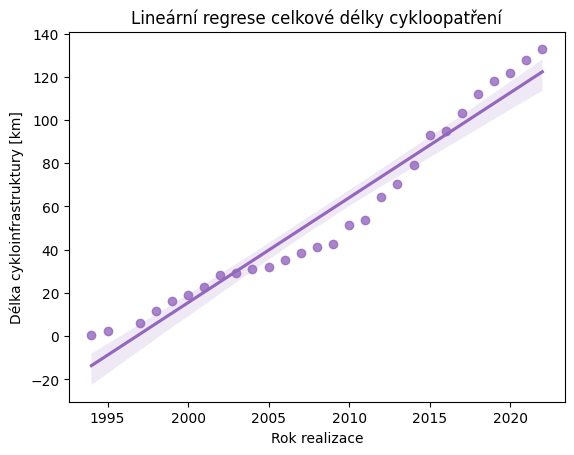

In [8]:
sns.set_palette(sns.color_palette(['tab:purple']))
g = sns.regplot(data=df_realizace, x='rok_realizace', y='total_delka', ci=95)
g.set_title("Lineární regrese celkové délky cykloopatření")
g.set(xlabel='Rok realizace', ylabel='Délka cykloinfrastruktury [km]', title='Lineární regrese celkové délky cykloopatření')


## Lineární regrese počtu cyklistů na jednotlivých usecích

In [9]:
# 4 years train, 1 year test
df_clean = df_dpnk.dropna(subset='dpnk_22')
df_clean.head()

,OBJECTID,GID_ROAD,data_2018,data_2019,data_2020,data_2021,dpnk_22,GlobalID,SHAPE_Length
0,1,3512,0,0,0,1,2.0,{18682DE8-C98F-4A17-B74E-13614BB9274E},0.002066
1,2,3515,3,5,3,34,15.0,{F7E4061B-AD4A-4E77-8FC2-1A310314A990},0.000113
2,3,3516,10,17,10,49,14.0,{56988C51-BD9B-4AC1-806F-C5DF0CD32CCB},0.000821
3,4,4168,2,4,2,7,38.0,{9A89DC54-871A-47C8-B35F-F5E2AD66ED8F},0.001342
4,5,4169,1,1,1,18,11.0,{6245952B-3ADC-4983-A9D6-D3BB6BE633D8},0.000630


In [10]:
# rozdeleni na train set/test set
X = df_clean[['data_2018', 'data_2019', 'data_2020', 'data_2021']]
y = df_clean['dpnk_22']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print('train score:', regr.score(X_train, y_train))
pred = regr.predict(X_test)
print('mean squared error:', mean_squared_error(y_test, pred))
print('r2 score:', r2_score(y_test, pred))
# predikce celeho roku 2022
pred2 = regr.predict(X)
print(f"predikce celeho roku 2022: {pred2.sum().round(0)}, realna hodnota 2022: {df2.loc[4, 'num_cyclists']}")

train score: 0.8965262258784883
mean squared error: 2380.900464730803
r2 score: 0.9024021440395821
predikce celeho roku 2022: 3655829.0, realna hodnota 2022: 3652385.0


## Načtení dat pomocí geopandas a tvorba pomocných sloupců

In [82]:
geo_dpnk = geopandas.read_file('./data_project3/dpnk_json.geojson')
geo_roads = geopandas.read_file('./data_project3/cykloopatreni_json.geojson')
geo_zero = geo_roads.loc[geo_roads[geo_roads['rok_realizace'] == 0].index]
# geo_roads =  geo_roads.drop(geo_roads[geo_roads['rok_realizace'] == 0].index) # deletes rows with year == 0

In [102]:
geo_roads = geo_roads[["rok_realizace", "delka", "geometry"]]

In [103]:
map_years = alt.Chart(geo_roads).mark_geoshape(filled=False).encode(alt.Color("rok_realizace", scale=alt.Scale(scheme="goldred"), legend=alt.Legend(title="Year")))
map_years

alt.Chart(...)

In [3]:
import pydeck as pdk
layer2 = pdk.Layer(
    type="PathLayer",
    data=geo_roads,
    pickable=True,
    get_color="color",
    width_scale=20,
    width_min_pixels=2,
    get_path="geometry",
    get_width=5,
)
initial_position = pdk.ViewState(latitude=49.196023157428, longitude=16.60988, zoom=11, pitch=0, bearing=0)
deck = pdk.Deck(layers=[layer2], initial_view_state=initial_position)

NameError: name 'geo_roads' is not defined

In [138]:
# Function that extracts the 2d list of coordinates from an input geometry
def my_geom_coord_extractor(input_geom):
    if (input_geom is None) or (input_geom is np.nan):
        return []
    else:
        if input_geom.geom_type[:len('multi')].lower() == 'multi':
            full_coord_list = []
            for geom_part in input_geom.geoms:
                geom_part_2d_coords = [[coord[0],coord[1]] for coord in list(geom_part.coords)]
                full_coord_list.append(geom_part_2d_coords)
        else:
            full_coord_list = [[coord[0],coord[1]] for coord in list(input_geom.coords)]
        return full_coord_list

# Applying the coordinate list extractor to the dataframe
geo_roads['path'] = geo_roads['geometry'].apply(my_geom_coord_extractor)

# gdf_polygon = geo_roads.unary_union.convex_hull 

In [139]:
geo_roads['color'] = geo_roads.apply(lambda x: (237, 28, 36), axis=1)
geo_roads

,rok_realizace,delka,geometry,coord_list,color,path
0,2021.0,149.770000,"MULTILINESTRING ((16.59897 49.19989, 16.60020 ...","[[[16.598970533000056, 49.199888574000056], [1...","(237, 28, 36)","[[[16.598970533000056, 49.199888574000056], [1..."
1,2017.0,71.870003,"MULTILINESTRING ((16.61335 49.19660, 16.61274 ...","[[[16.613349483000036, 49.19659754200006], [16...","(237, 28, 36)","[[[16.613349483000036, 49.19659754200006], [16..."
2,2022.0,53.349998,"MULTILINESTRING ((16.64647 49.19613, 16.64645 ...","[[[16.646472369000037, 49.19612806500004], [16...","(237, 28, 36)","[[[16.646472369000037, 49.19612806500004], [16..."
3,2021.0,248.250000,"MULTILINESTRING ((16.59679 49.19958, 16.59631 ...","[[[16.596792452000045, 49.19958265000008], [16...","(237, 28, 36)","[[[16.596792452000045, 49.19958265000008], [16..."
4,2015.0,81.139999,"MULTILINESTRING ((16.60728 49.19359, 16.60718 ...","[[[16.607281595000075, 49.193585658000075], [1...","(237, 28, 36)","[[[16.607281595000075, 49.193585658000075], [1..."
...,...,...,...,...,...,...
594,2015.0,17.150000,"MULTILINESTRING ((16.60907 49.19665, 16.60931 ...","[[[16.609071001000075, 49.196646298000076], [1...","(237, 28, 36)","[[[16.609071001000075, 49.196646298000076], [1..."
595,2014.0,130.990010,"MULTILINESTRING ((16.61700 49.19058, 16.61654 ...","[[[16.61699883800003, 49.19057883600004], [16....","(237, 28, 36)","[[[16.61699883800003, 49.19057883600004], [16...."
596,2014.0,153.330000,None,[],"(237, 28, 36)",[]
597,2014.0,132.759990,None,[],"(237, 28, 36)",[]


In [4]:
geo_roads['centroid'] = geo_roads['geometry'].to_crs(crs=3857).centroid # to metres
geo_roads['centroid'] = geo_roads['centroid'].to_crs(crs=4326) # to degrees
geo_roads.head()

,ObjectId,ogcfid,typ_opatreni,rok_realizace,delka,datum_exportu,GlobalID,SHAPE_Length,geometry,centroid
0,1,639,Jízda cyklistů v protisměru (piktogram),2021.0,149.770000,2022-12-16 00:00:00+00:00,{F1050389-0266-46A5-8281-AD60711AE90A},0.002029,"MULTILINESTRING ((16.59897 49.19989, 16.60020 ...",POINT (16.59998 49.20003)
1,2,297,Jízda cyklistů v protisměru (piktogram),2017.0,71.870003,2022-12-16 00:00:00+00:00,{04371385-F368-42FD-9B83-3DAD4033D0EE},0.000657,"MULTILINESTRING ((16.61335 49.19660, 16.61274 ...",POINT (16.61304 49.19648)
2,3,712,Stezka pro chodce s povoleným vjezdem cyklistů,2022.0,53.349998,2022-12-16 00:00:00+00:00,{39E0D50A-C566-4DF7-9BFA-6F603262172E},0.000486,"MULTILINESTRING ((16.64647 49.19613, 16.64645 ...",POINT (16.64642 49.19636)
3,4,641,Jízda cyklistů v protisměru (piktogram),2021.0,248.250000,2022-12-16 00:00:00+00:00,{84B6FC27-C62C-4AB4-9761-2117FF06B4A0},0.003363,"MULTILINESTRING ((16.59679 49.19958, 16.59631 ...",POINT (16.59513 49.19935)
4,5,336,Piktogramový koridor pro cyklisty - V20,2015.0,81.139999,2022-12-16 00:00:00+00:00,{C5C495C3-0BB3-4AEA-BAF0-8C61C062742A},0.000821,"MULTILINESTRING ((16.60728 49.19359, 16.60718 ...",POINT (16.60707 49.19391)


In [14]:
geo_dpnk['centroid'] = geo_dpnk['geometry'].to_crs(crs=3857).centroid # to metres
geo_dpnk['centroid'] = geo_dpnk['centroid'].to_crs(crs=4326) # to degrees
geo_dpnk['sum_years'] = geo_dpnk[geo_dpnk.columns[2:7]].sum(axis=1)
geo_dpnk['mean_years'] = geo_dpnk[geo_dpnk.columns[2:7]].mean(axis=1)
geo_dpnk.head()

,OBJECTID,GID_ROAD,data_2018,data_2019,data_2020,data_2021,dpnk_22,GlobalID,SHAPE_Length,geometry,centroid,sum_years,mean_years
0,1,3512.0,0,0,0,1,2.0,{18682DE8-C98F-4A17-B74E-13614BB9274E},0.002066,"MULTILINESTRING ((16.69839 49.30872, 16.69838 ...",POINT (16.69844 49.30969),3.0,0.6
1,2,3515.0,3,5,3,34,15.0,{F7E4061B-AD4A-4E77-8FC2-1A310314A990},0.000113,"MULTILINESTRING ((16.66312 49.29681, 16.66320 ...",POINT (16.66316 49.29685),60.0,12.0
2,3,3516.0,10,17,10,49,14.0,{56988C51-BD9B-4AC1-806F-C5DF0CD32CCB},0.000821,"MULTILINESTRING ((16.66234 49.29709, 16.66312 ...",POINT (16.66273 49.29695),100.0,20.0
3,4,4168.0,2,4,2,7,38.0,{9A89DC54-871A-47C8-B35F-F5E2AD66ED8F},0.001342,"MULTILINESTRING ((16.64117 49.39327, 16.64130 ...",POINT (16.64183 49.39321),53.0,10.6
4,5,4169.0,1,1,1,18,11.0,{6245952B-3ADC-4983-A9D6-D3BB6BE633D8},0.000630,"MULTILINESTRING ((16.64110 49.39303, 16.64173 ...",POINT (16.64142 49.39304),32.0,6.4


## Clustering četnosti cyklistů na jednotlivých úsecích
Birch clustering algoritmus

In [14]:
# pouzity centroidy jednotlivych useku
centroids = pd.concat([geo_dpnk['centroid'].x, geo_dpnk['centroid'].y], axis=1)
brc = Birch(threshold=0.01, n_clusters=12, branching_factor=10).fit_predict(centroids)
geo_dpnk['birch'] = brc
geo_dpnk['birch_cmap'] = geo_dpnk['birch'].map(geo_dpnk[['sum_years', 'birch']].groupby(['birch']).sum().to_dict()['sum_years'])

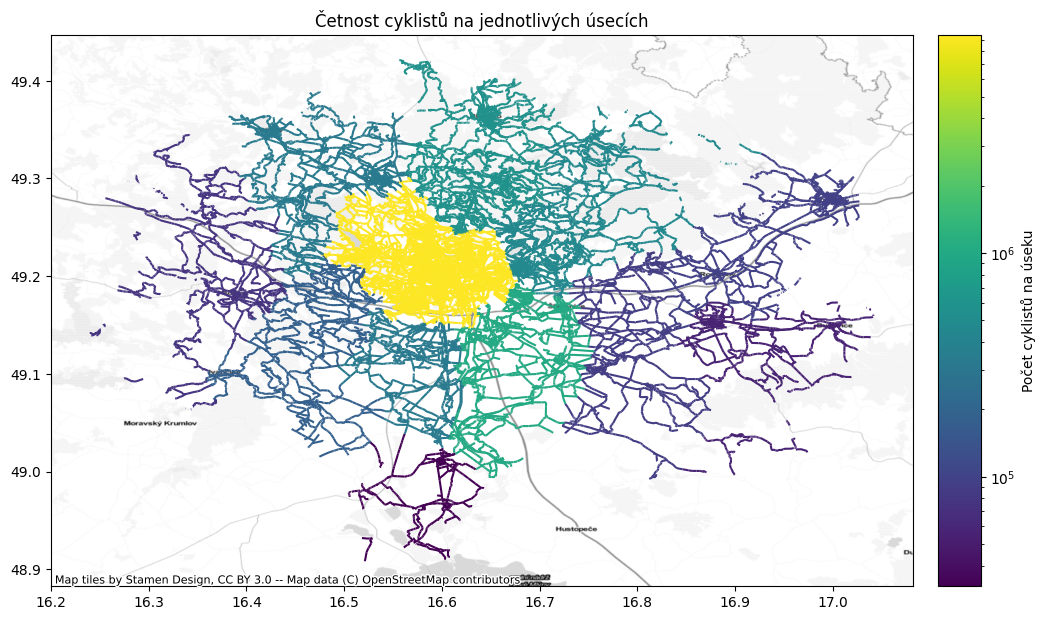

In [15]:
fig, ax = plt.subplots(figsize=(12, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
label = {"label": 'Počet cyklistů na úseku'}
norm = colors.LogNorm(vmin=geo_dpnk['birch_cmap'].min(), vmax=geo_dpnk['birch_cmap'].max())
geo_dpnk.plot(markersize=0.6, ax=ax, column='birch_cmap', cmap='viridis', cax=cax, legend=True, legend_kwds=label, norm=norm)
ax.set_title("Četnost cyklistů na jednotlivých úsecích")
ctx.add_basemap(ax, crs=geo_dpnk.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

## Zobrazení realizace cykloopatření podle roků

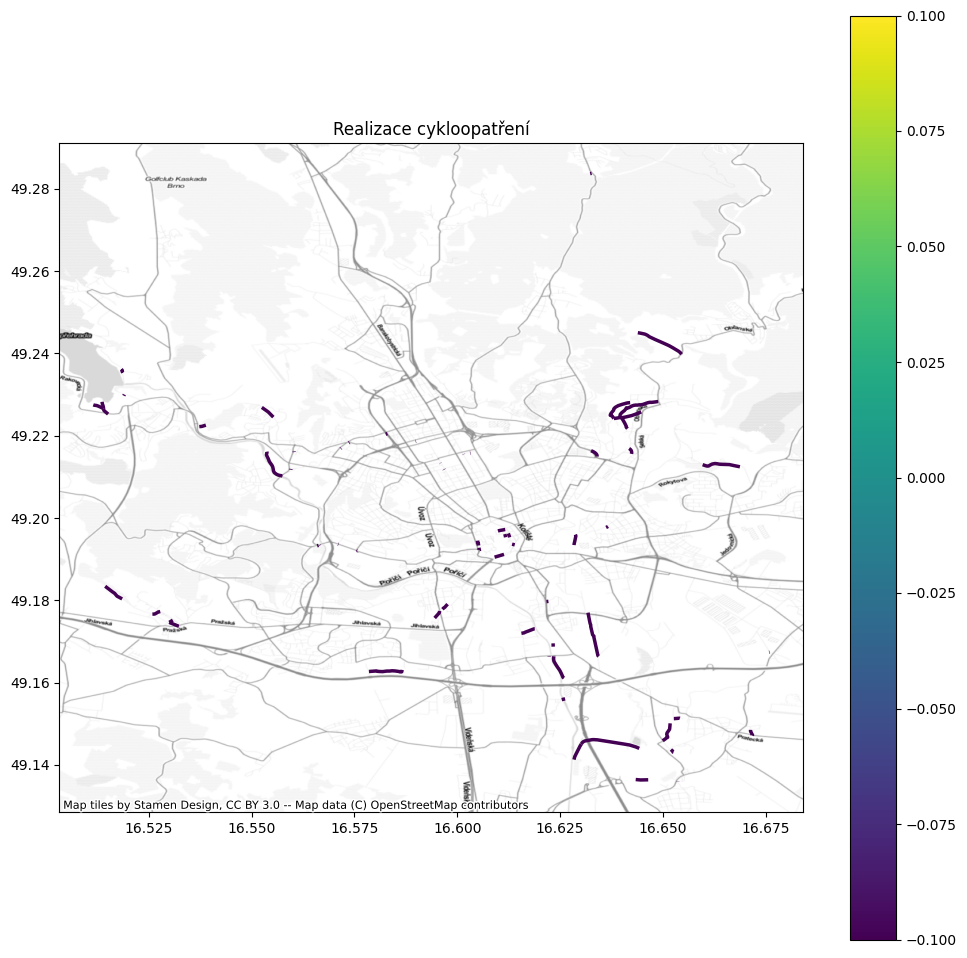

In [42]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.25)
# label = {"label": 'Rok realizace'}
geo_zero.plot(ax=ax, column='rok_realizace', legend=True, linewidth=2.5)
ax.set_title("Realizace cykloopatření")
ctx.add_basemap(ax, crs=geo_roads.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

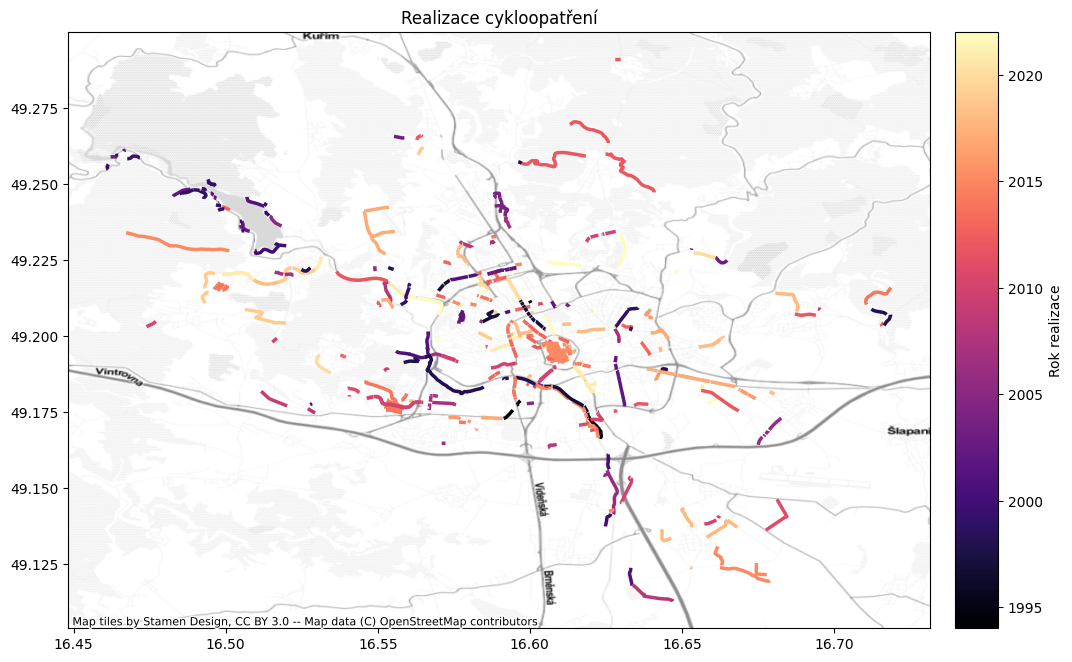

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
label = {"label": 'Rok realizace'}
geo_roads.plot(ax=ax, column='rok_realizace', cax=cax, legend=True, legend_kwds=label, linewidth=2.5, cmap='magma')
ax.set_title("Realizace cykloopatření")
ctx.add_basemap(ax, crs=geo_roads.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

## Zobrazení nejvíce frekventovaných úseků
Průměrně měsíčně více než 300 cyklistů

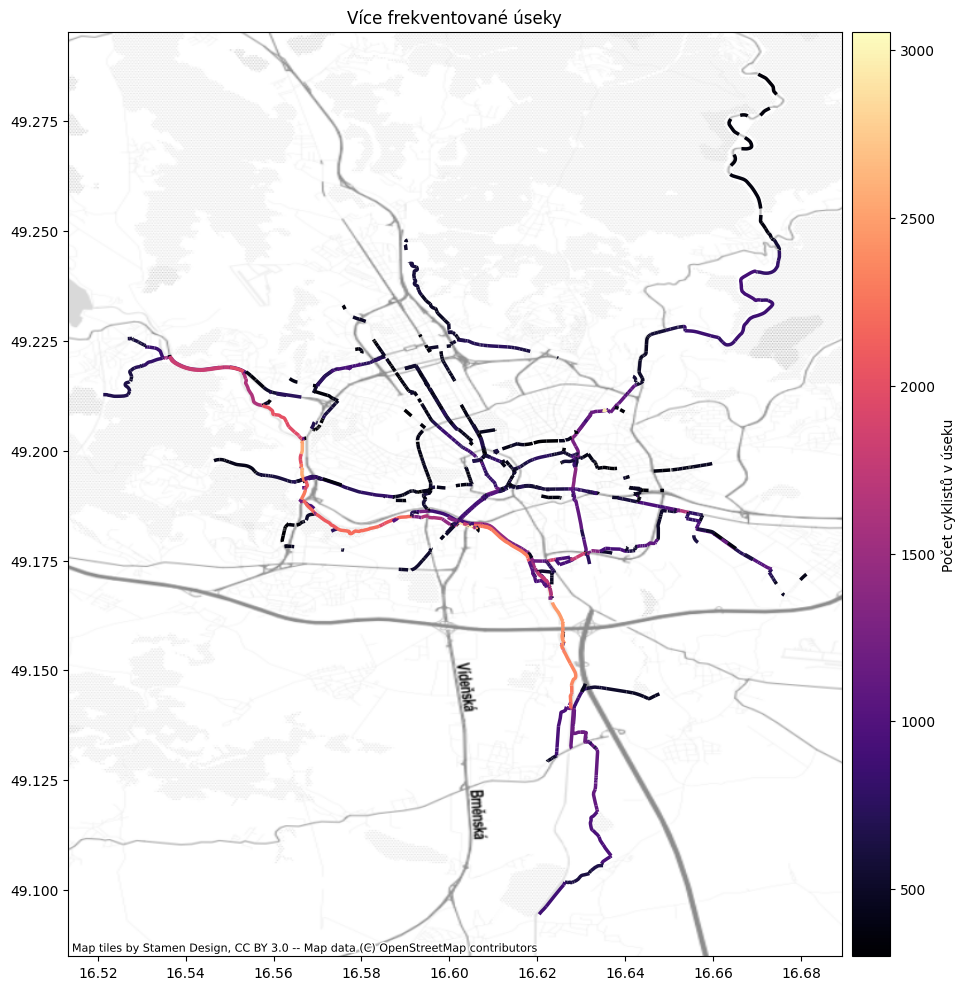

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
label = {"label": 'Počet cyklistů v úseku'}
geo_dpnk[geo_dpnk['mean_years'] > 300].plot(ax=ax, column='dpnk_22', legend=True, legend_kwds=label, vmin=300, cmap='magma', linewidth=2.5, cax=cax)
ax.set_title("Více frekventované úseky")
ctx.add_basemap(ax, crs=geo_dpnk.crs.to_string(), source=ctx.providers.Stamen.TonerLite)